Firstly we need to install Sunpy library for working with solar images

In [ ]:
# Firstly, we install SunPy package to work with solar images
!pip install sunpy

     |████████████████████████████████| 6.1 MB 6.7 MB/s 
     |████████████████████████████████| 1.3 MB 42.6 MB/s 
     |████████████████████████████████| 142 kB 60.0 MB/s 
     |████████████████████████████████| 294 kB 44.5 MB/s 


In [ ]:
#installing libraries
import sunpy
import sunpy.map
from astropy.io import fits
from astropy import units as u
import matplotlib.pyplot as plt  #for plotting
import pandas as pd
from scipy import ndimage
import numpy as np
import math
from google.colab import files
from scipy.stats import pearsonr

The code is written for working in Google Colab. The data can be loaded directly from the Google Drive or be uploaded manually from the computer

In [ ]:
#add personal google drive to store the files and work with them
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!mkdir data #make new folder in workspace
!gdown --id 1wnpXFJ5S-ZfidCi-rAMeLtcEmPTwDJ3K -O 2016_June.zip  #download .zip from google drive to this folder
!unzip "2016_June.zip" #open the .zip file to read all files
!gdown --id 1gHOcsXa6wCsvi8ZAMQiGdm55nqhCjb3v -O 2016_December.zip
!unzip "2016_December.zip"

Downloading...
From: https://drive.google.com/uc?id=1wnpXFJ5S-ZfidCi-rAMeLtcEmPTwDJ3K
To: /content/2016_June.zip
56.0MB [00:00, 73.0MB/s]
Archive:  2016_June.zip
   creating: 2016_June/
  inflating: 2016_June/kanz_bband_fd_20160610_1042.fts  
  inflating: 2016_June/kanz_bband_fd_20160611_1141.fts  
  inflating: 2016_June/kanz_bband_fd_20160612_0942.fts  
  inflating: 2016_June/kanz_bband_fd_20160613_0632.fts  
  inflating: 2016_June/kanz_bband_fd_20160614_1113.fts  
  inflating: 2016_June/kanz_bband_fd_20160615_0729.fts  
  inflating: 2016_June/kanz_bband_fd_20160616_0739.fts  
  inflating: 2016_June/kanz_bband_fd_20160617_0613.fts  
  inflating: 2016_June/kanz_bband_fd_20160618_0559.fts  
  inflating: 2016_June/kanz_bband_fd_20160619_0731.fts  
  inflating: 2016_June/kanz_bband_fd_20160621_0629.fts  
  inflating: 2016_June/kanz_bband_fd_20160622_0809.fts  
Downloading...
From: https://drive.google.com/uc?id=1gHOcsXa6wCsvi8ZAMQiGdm55nqhCjb3v
To: /content/2016_December.zip
27.4MB [00:00

In [ ]:
# In the original Astropy package of units, there is no angstrom, however, it will be needed for FITS files to work correctly, so we deifine the unit by ourselves
ANG = u.def_unit('ANG', 10**(-10) * u.m)
u.add_enabled_units([ANG]);

# **Data processing of the  December 2010 list**

In [ ]:
#create a list with names of the files (winter):
data_list_win = ['kanz_bband_fd_20101204_1339.fts',
                'kanz_bband_fd_20101205_1111.fts',
                'kanz_bband_fd_20101206_0936.fts',
                'kanz_bband_fd_20101207_1255.fts',
                'kanz_bband_fd_20101208_0814.fts',
                'kanz_bband_fd_20101209_1312.fts',
                'kanz_bband_fd_20101210_1102.fts',
                'kanz_bband_fd_20101211_1008.fts']

Let's check the first map in a row

In [ ]:
data, header = sunpy.io.fits.read('2010_December/'+ data_list_win[5])[0]  #opening the first map - we can also check other maps by their number
# The funtion will rotate the image on SOLAR_P0 angle clockwise to place the North direction straight up
data = ndimage.rotate(data, header['SOLAR_P0'], reshape=False) 
map = sunpy.map.Map(data, header) #creating  map from data and header


/usr/local/lib/python3.7/dist-packages/sunpy/util/decorators.py:378: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.

  new_val = prop(instance)


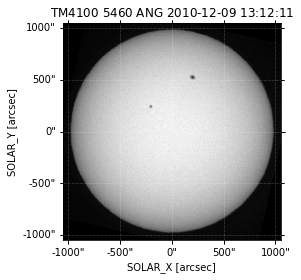

In [ ]:
#to plot the calibrated map
map.plot()

we can check maps one by one to define the coordinates of the sunspots

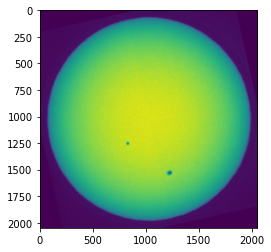

In [ ]:
#to show in pixels as an image - then vertical axis is upside down
plt.imshow(map.data)

"For" loop implemented in this cell will read each file, rotate the picture to place the North direction straight up, collect all the dates and coordinates

In [ ]:
#we define the coordinates of the sunspots using maps
X_spot=[400,520,665,865,1005,1220,1370,1515]
Y_spot=[580,570,560,555,535,520,510,505]

#create empty lists to store the coordinates
lat = []
lon = []
dates = []

#in a loop we define lat, lon of the sunspot + date of every image
for i in range (len(X_spot)):
  data, header = sunpy.io.fits.read('2010_December/'+ data_list_win[i])[0]
  data = ndimage.rotate(data, header['SOLAR_P0'], reshape=False) #rotating the map
  map = sunpy.map.Map(data, header) #creating new map with rotated data
  dates.append(pd.to_datetime(header['DATE-OBS'], format='%Y-%m-%dT%H:%M:%S')) #add dates to the list

  #define polar coords according to the instructions
  Y=X_spot[i]-1024
  Z=Y_spot[i]-1024 
  Z=1024-Y_spot[i] 

  X=(header['SOLAR_R'] ** 2-Y**2-Z**2)**0.5
  Theta=np.arccos(Z / header['SOLAR_R'])*(180 / np.pi)

  #adding lat, lon to the lists
  lat.append(float(90-Theta))
  lon.append(math.atan2(Y,X)*(180 / np.pi))

Now we plot the dependence of the latitude on time

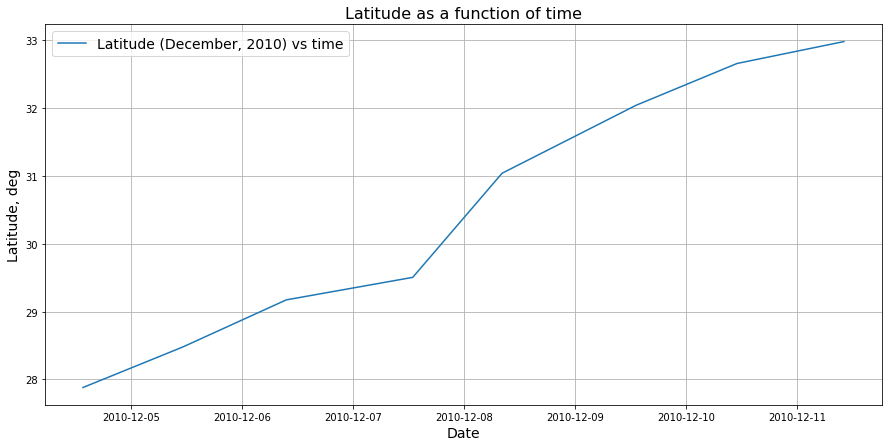

In [ ]:
#here we use matplotlib library to plot
fig = plt.figure(figsize=(15, 7))
plt.plot(dates, lat, label = 'Latitude (December, 2010) vs time')
plt.title('Latitude as a function of time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Latitude, deg', fontsize=14)
plt.legend(fontsize=14)
plt.grid()

Now let's plot the dependence of the longitude on time

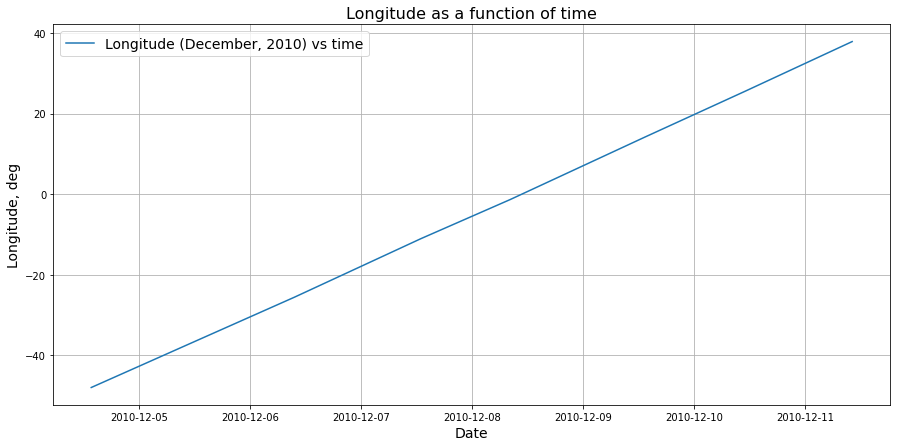

In [ ]:
fig = plt.figure(figsize=(15, 7))
plt.plot(dates, lon, label = 'Longitude (December, 2010) vs time')
plt.title('Longitude as a function of time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Longitude, deg', fontsize=14)
plt.legend(fontsize=14)
plt.grid()

Dependence of the latitude on the longitude


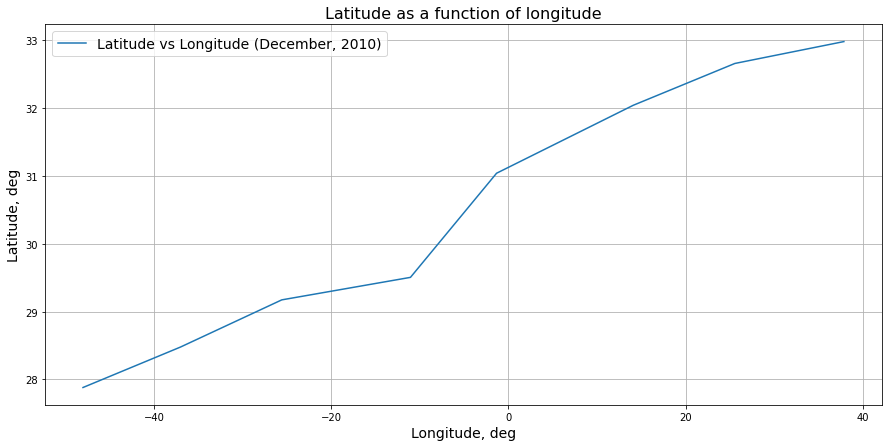

In [ ]:
fig = plt.figure(figsize=(15, 7))
plt.plot(lon, lat, label = 'Latitude vs Longitude (December, 2010)')
plt.title('Latitude as a function of longitude', fontsize=16)
plt.xlabel('Longitude, deg', fontsize=14)
plt.ylabel('Latitude, deg', fontsize=14)
plt.legend(fontsize=14)
plt.grid()

defining the correlation coefficient

In [ ]:
corr, _ = pearsonr(lon, lat)
print('Pearsons correlation coefficient: %.3f' % corr)

Pearsons correlation coefficient: 0.987


**From these three graphs above, one may notice that the dependencies of both latitude and longitude on time are
quite close to linear. Thus, the rotation rates related to the change of both latitude and longitude on time are more or
less constant. Moreover, it results in the fact that the values of latitude and longitude are correlated - it can be seen
from the Pearsons correlation coefficient which is quite close to 1.**

We determine the angular velocity of solar rotation per day using the obtained longitude and taking into account the time between images.

In [ ]:
# The result corresponds to the synodic angular velocity
omega_synod = []
for i in range(len(dates) - 1):
  delta = dates[i + 1] - dates[i]
  days = delta.days + delta.seconds / 60 / 60 / 24
  omega_synod.append((lon[i + 1] - lon[i]) / days) # deg / day

Sidereal rotation rate

In [ ]:
# Earth orbital period around the Sun:
p_earth = 365.2564 # days
omega_sid_Dec = []
for i in range(len(dates) - 1):
  p_synod = 360 / omega_synod[i] # days
  # siderial rotation period, days
  p_sid = p_earth * p_synod / (p_earth + p_synod) # days
  # siderial rotation rate
  omega_sid = 360 / p_sid # deg / day
  omega_sid_Dec.append(omega_sid)

Finally, we determine the functional form of solar differential rotation obtained from statistical studies:

In [ ]:
a = 14.55 # deg / day
b = -2.87 # deg / day
lat_array = np.linspace(-50, 50, 100) #defining set of points to plot
omega_sid_theory = a + b * np.sin(lat_array*np.pi/180) ** 2

Dependency of the latitude values obtained from the dataset VS the dependency known from statistical studies

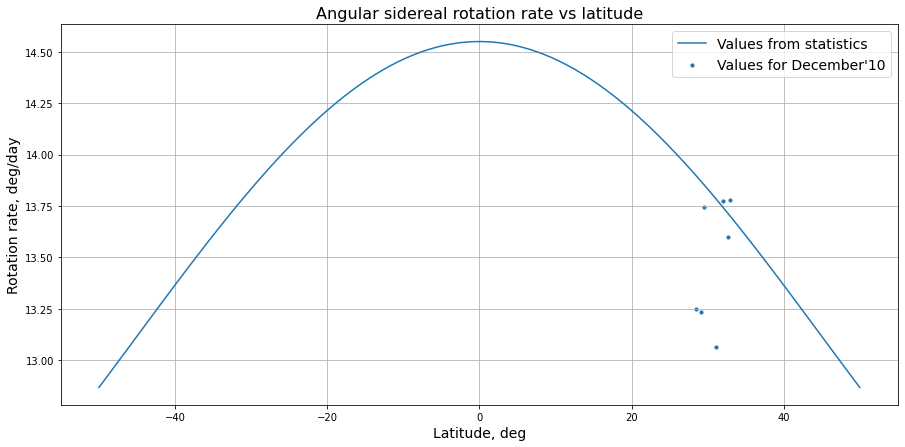

In [ ]:
fig = plt.figure(figsize=(15, 7))
plt.scatter(lat[1:], omega_sid_Dec, label='Values for December\'10', s = 10)
plt.plot(lat_array, omega_sid_theory, label='Values from statistics')
plt.title('Angular sidereal rotation rate vs latitude', fontsize=16)
plt.xlabel('Latitude, deg', fontsize=14)
plt.ylabel('Rotation rate, deg/day', fontsize=14)
plt.legend(fontsize=14)
plt.grid()


As a result, we see that the scatter plot of the latitude values which were obtained during the dataset's processing
shows errors in comparison with the given curve from statistics. However, the data scattering lies within 1.5 deg per
day which is a valid result if we recall the original statistics curve (it reveals that the higher the module of the latitude
value, the bigger the error). The errors may have appeared at the stage where we estimated roughly the spot we track.

# **Data processing of the June 2016 list**

In [ ]:
#List of the files will be used (summer):
data_list_sum = ['kanz_bband_fd_20160610_1042.fts',
                 'kanz_bband_fd_20160611_1141.fts',
                  'kanz_bband_fd_20160612_0942.fts',
                  'kanz_bband_fd_20160613_0632.fts',
                  'kanz_bband_fd_20160614_1113.fts',
                  'kanz_bband_fd_20160615_0729.fts',
                  'kanz_bband_fd_20160616_0739.fts',
                  'kanz_bband_fd_20160617_0613.fts',
                  'kanz_bband_fd_20160618_0559.fts',
                  'kanz_bband_fd_20160619_0731.fts',
                  'kanz_bband_fd_20160621_0629.fts',
                  'kanz_bband_fd_20160622_0809.fts']

/usr/local/lib/python3.7/dist-packages/sunpy/util/decorators.py:378: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.

  new_val = prop(instance)


Observatory,KPT
Instrument,KPDC
Detector,TM4200-5
Measurement,5460.0 ANG
Wavelength,5460.0 ANG
Observation Date,2016-06-10 10:42:07
Exposure Time,0.002423 s
Dimension,[2048. 2048.] pix
Coordinate System,helioprojective
Scale,[1.0224 1.0224] arcsec / pix
Reference Pixel,[1023.5 1023.5] pix

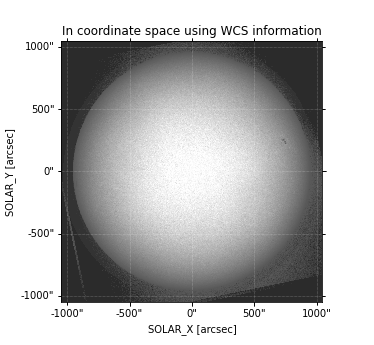
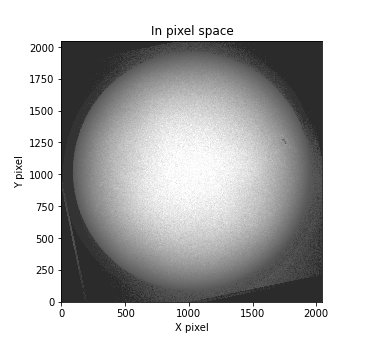
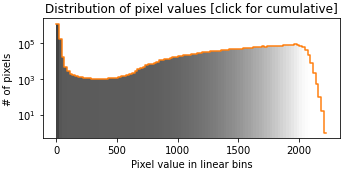
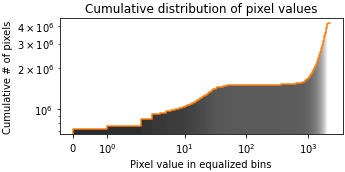

In [ ]:
#here we can check every map one by one
data_1, header_1 = sunpy.io.fits.read('2016_June/'+ data_list_sum[0])[0] 
data_1 = ndimage.rotate(data_1, header_1['SOLAR_P0'], reshape=False)
map_1 = sunpy.map.Map(data_1, header_1)
map_1

We repeat the same loop as for the previous data set:

In [ ]:
X_spot=[122, 198, 285, 412, 622, 792 ,1005, 1209, 1411, 1605, 1851, 1928]
Y_spot=[1124, 1125, 1132, 1133, 1143, 1143, 1148, 1148, 1147, 1145, 1134, 1127]

lat_June = []
lon_June = []
dates_June = []

for i in range (len(X_spot)):
  data, header = sunpy.io.fits.read('2016_June/'+ data_list_sum[i])[0]
  data = ndimage.rotate(data, header['SOLAR_P0'], reshape=False)
  map = sunpy.map.Map(data, header)
  dates_June.append(pd.to_datetime(header['DATE-OBS'], format='%Y-%m-%dT%H:%M:%S'))


  Y=X_spot[i]-1024
  Z=Y_spot[i]-1024 
  Z=1024-Y_spot[i] 


  X=(header['SOLAR_R'] ** 2-Y**2-Z**2)**0.5
  Theta=np.arccos(Z / header['SOLAR_R'])*(180 / np.pi)
  lat_June.append(float(90-Theta))

  lon_June.append(math.atan2(Y,X)*(180 / np.pi))

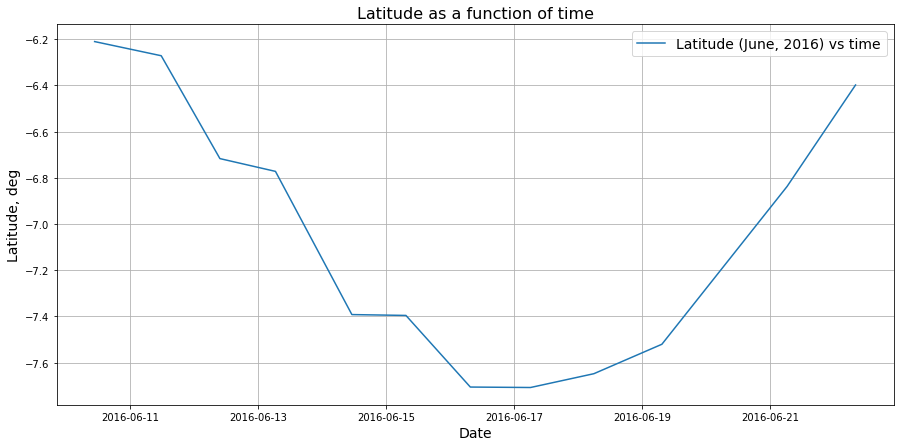

In [ ]:
# Now let us plot the dependence of the latitude on time
fig = plt.figure(figsize=(15, 7))
plt.plot(dates_June, lat_June, label = 'Latitude (June, 2016) vs time')
plt.title('Latitude as a function of time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Latitude, deg', fontsize=14)
plt.legend(fontsize=14)
plt.grid()

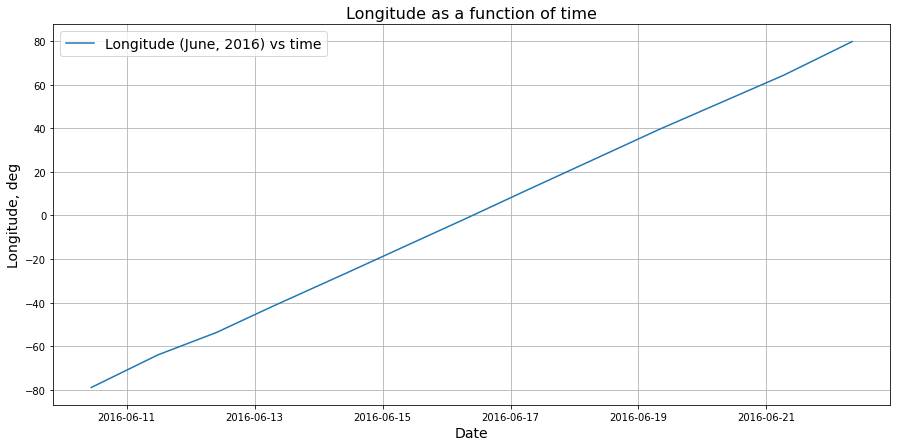

In [ ]:
# Now let us plot the dependence of the longitude on time
fig = plt.figure(figsize=(15, 7))
plt.plot(dates_June, lon_June, label = 'Longitude (June, 2016) vs time')
plt.title('Longitude as a function of time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Longitude, deg', fontsize=14)
plt.legend(fontsize=14)
plt.grid()

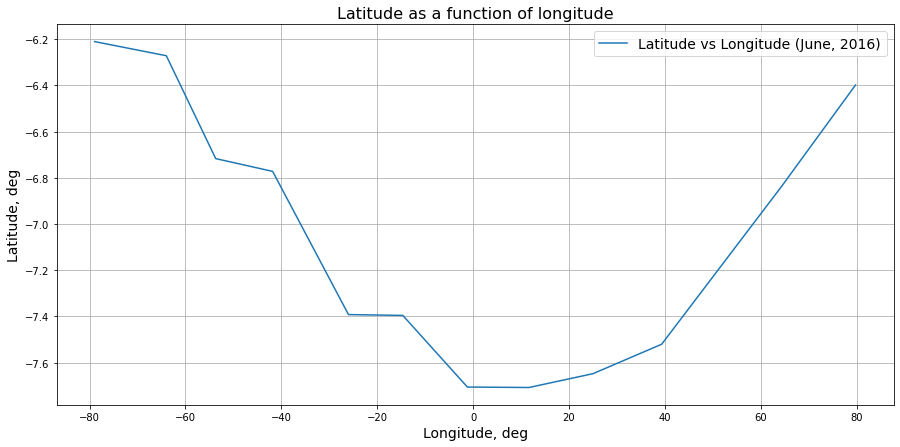

In [ ]:
# Let us plot the dependence of the latitude on the longitude
fig = plt.figure(figsize=(15, 7))
plt.plot(lon_June, lat_June, label = 'Latitude vs Longitude (June, 2016)')
plt.title('Latitude as a function of longitude', fontsize=16)
plt.xlabel('Longitude, deg', fontsize=14)
plt.ylabel('Latitude, deg', fontsize=14)
plt.legend(fontsize=14)
plt.grid()

Here we may see a completely different behaviour of the functions: the latitude changes in a non-linear way in
comparison with the previous winter case where we considered sunspot at high latitudes and we saw a linear
dependency, while the longitude on time function remains linear as it was before. As a result, there is no correlation
of latitudes and longitudes in this case. We can see the noticable nonlinear relation - performance of the fact that Sun has 3d surface. 

In [ ]:
omega_synod_June = []
for i in range(len(dates_June) - 1):
  delta = dates_June[i + 1] - dates_June[i]
  days = delta.days + delta.seconds / 60 / 60 / 24
  omega_synod_June.append((lon_June[i + 1] - lon_June[i]) / days) # deg / day

In [ ]:
omega_sid_June = []
for i in range(len(dates_June) - 1):
    p_synod = 360 / omega_synod_June[i] # days
    # siderial rotation period, days
    p_sid = p_earth * p_synod / (p_earth + p_synod) # days
    # siderial rotation rate
    omega_sid = 360 / p_sid # deg / day
    omega_sid_June.append(omega_sid) #add the number to the list

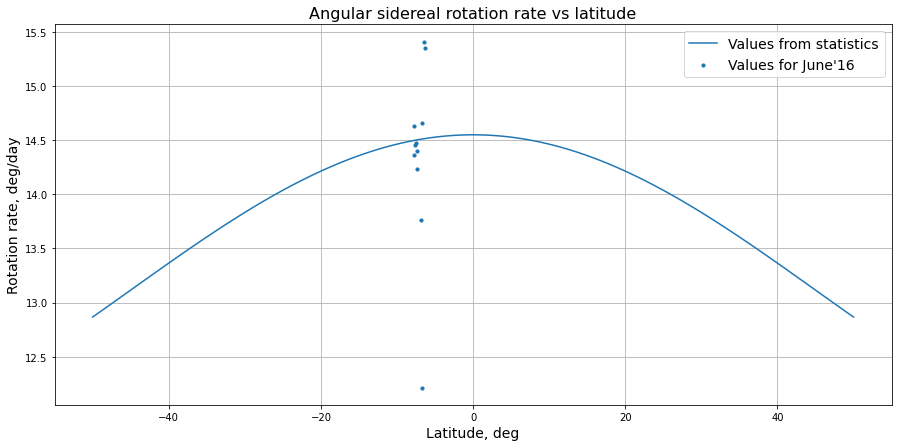

In [ ]:
# And here we plot both the dependency of the latitude values obtained from the dataset and the dependency known from statistical studies
fig = plt.figure(figsize=(15, 7))
plt.scatter(lat_June[1:], omega_sid_June, label='Values for June\'16', s = 10)
plt.plot(lat_array, omega_sid_theory, label='Values from statistics')
plt.title('Angular sidereal rotation rate vs latitude', fontsize=16)
plt.xlabel('Latitude, deg', fontsize=14)
plt.ylabel('Rotation rate, deg/day', fontsize=14)
plt.legend(fontsize=14)
plt.grid()

On this graph, we notice that the data scattering from the calculated values from statistical studies is less significant
in this case (less than 0.5 degree on average) which was also seen on the original graph presented on the lecture.
However, even there we used rough estimations of the spot's center of mass which may have led to the errors.

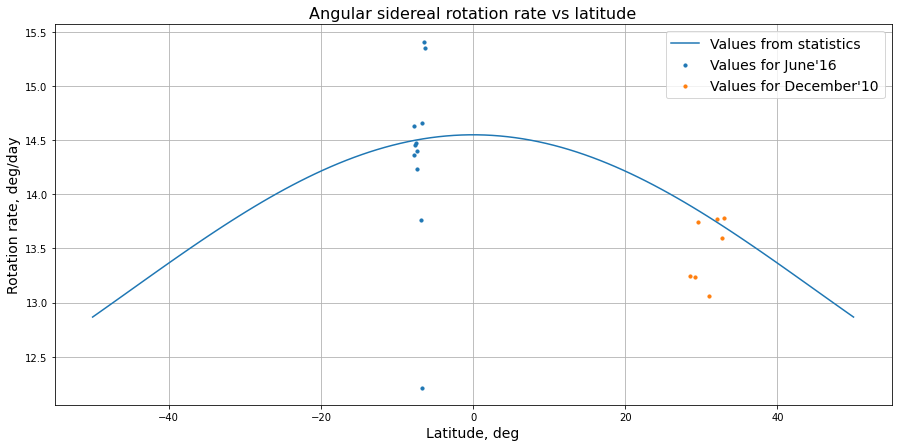

In [ ]:
# Now we are interested to see both plots together
fig = plt.figure(figsize=(15, 7))
plt.scatter(lat_June[1:], omega_sid_June, label='Values for June\'16', s= 10)
plt.scatter(lat[1:], omega_sid_Dec, label='Values for December\'10', s= 10)
plt.plot(lat_array, omega_sid_theory, label='Values from statistics')
plt.title('Angular sidereal rotation rate vs latitude', fontsize=16)
plt.xlabel('Latitude, deg', fontsize=14)
plt.ylabel('Rotation rate, deg/day', fontsize=14)
plt.legend(fontsize=14)
plt.grid()

As a result, we see that the rotation rate obtained from the dataset with a near-equator sunspot is on average 0.50-
0.75 degree higher than for the value from the dataset with high latitude sunspot. The dispersion of the points is
quite high due to several rought estimations made within the assignment's implementation.

# **Appendix**
we also can try to define the sunspot coordiates automatically, using the thresholding method

In [ ]:
# We create emply lists for the data needed for further processing
SPOT_X = []
SPOT_Y = []
SPOT_Z = []
lat = []
lon = []
dates = []

for i in range (len(data_list_win)):
  data, header = sunpy.io.fits.read('2010_December/'+ data_list_win[i])[0]  #opening december data
  header['cunit1'] = 'arcsec' #fixing fits metadata
  header['cunit2'] = 'arcsec' 
  # SOLAR_P0 header - Original position angle of the solar north pole measured eastward (counterclockwise) from plate "north" (degrees)
  # The funtion will rotate the image on SOLAR_P0 angle clockwise to place the North direction straight up
  data = ndimage.rotate(data, header['SOLAR_P0'], reshape=False)  #image rotation for the SOLAR_P0 angle
  map = sunpy.map.Map(data, header) #creating rotated map

  # We want to collect all the dates
  dates.append(pd.to_datetime(header['DATE-OBS'], format='%Y-%m-%dT%H:%M:%S'))

  # Here we work with the intensities of the pixels to transfer them to the binary scale
  # All the pixels with intensities more than 300 and less then 100 will go white, while the rest of them will go black
  # We need this procedure to easily identify later the spot on the picture automatically (! but we also define the coordinates of the sunspots just manually)
  for k in range (0, 2048):
    for j in range (0, 2048):
      if (data[k][j]) > 300 or (data[k][j] < 100):
          data[k][j] = 800
      else:
          data[k][j] = 0

  # Once the images are in a binary scale, we call a function which will find all the contours it can on the picture
  contours = map.contour(100)

  # It was found that the "size" of the spot's contour will be somewhere in between 75 and 140 units, so we extract only these contours
  n = []
  for k in range(len(contours)):
    if 75 < len(contours[k]) < 140:
      n.append(k)

  len_spot = np.array([133, 79, 91, 99, 103, 103, 101, 105])


  # And here we find the coordinates of the spot [although it will be a very rough estimate of the center of mass for the spot]
  for k in range(len(n)):
    if len(contours[n[k]]) == len_spot[i]:
        center = int(len(contours[n[k]])/2)
        SPOT_Y.append(contours[n[k]][center].Tx / contours[n[k]][center].Tx.unit / 1.02274) #add the coordinate to the list by append
        SPOT_Z.append(contours[n[k]][center].Ty / contours[n[k]][center].Ty.unit / 1.02274)

        SPOT_X.append((header['SOLAR_R'] ** 2 - SPOT_Y[i] ** 2 - SPOT_Z[i] ** 2) ** 0.5)

        #define the polar coordinates
        theta = (np.arccos(SPOT_Z[i] / header['SOLAR_R']) * 180 / np.pi) / u.rad
        lat.append(float(90 - theta))
        lon.append(math.atan2(SPOT_Y[i], SPOT_X[i]) * 180 / np.pi)